In [165]:
# Michał Bogucki, Marcin Janeczko, Aleksander Tym

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv("data.csv")

# We decided to drop column with id values, as it does not provide any valuable information for us 
df = df.drop("Unnamed: 0", axis=1)

# The first important issue is to prepare data for analysis. We checked how many missing values are in each column
# to see how we can handle with missing data. Number of "true" records means number of missing values in each column 
print("before: ")
for i in df.columns.values:
    print(pd.isnull(df).groupby(i).size(), 
          "\n-------------------")

before: 
survived
False    1309
dtype: int64 
-------------------
pclass
False    1309
dtype: int64 
-------------------
sex
False    1309
dtype: int64 
-------------------
age
False    1046
True      263
dtype: int64 
-------------------
sibsp
False    1309
dtype: int64 
-------------------
parch
False    1309
dtype: int64 
-------------------
fare
False    1308
True        1
dtype: int64 
-------------------
embarked
False    1307
True        2
dtype: int64 
-------------------


fare
False    1306
dtype: int64 
-------------------
embarked
False    1306
dtype: int64 
-------------------
age
False    1306
dtype: int64


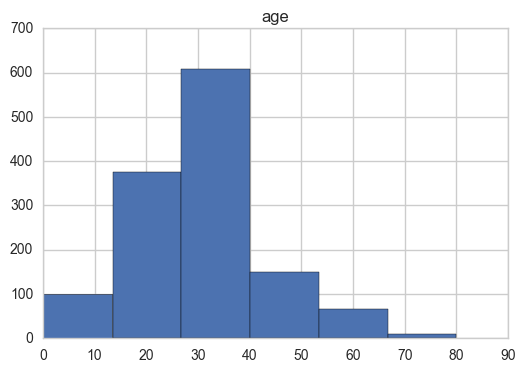

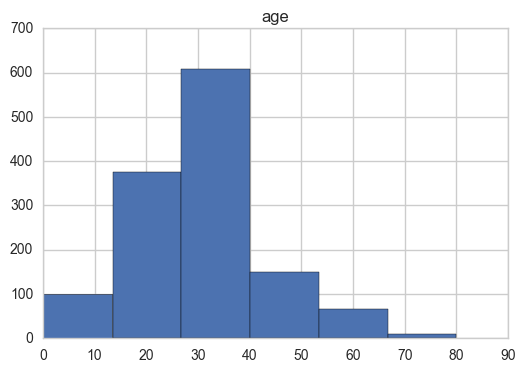

In [226]:
# There were:
# - 263 missing values in Age
# - 2 missing values in Embarked
# - 1 missing value in Fare
# We decided to drop records with missing Fare and Embarked values (because there is only 3 of them in total)
# We also decided to replace missing Age values with probability as in distribution of non-missing age values

df = df[pd.notnull(df.fare)]
df = df[pd.notnull(df.embarked)]

pd.DataFrame.hist(df,"age", bins=6)
df.loc[np.isnan(df["age"]),"age"] = np.random.normal(df["age"].mean(), df["age"].std())
pd.DataFrame.hist(df,"age", bins=6)
#We print histograms before and after inserting missing age values

# We check if everything was done correctly (all values false, 1309 - 3 = 1306 in total)    
print(pd.isnull(df).groupby("fare").size(),"\n-------------------")
print(pd.isnull(df).groupby("embarked").size(), "\n-------------------")
print(pd.isnull(df).groupby("age").size())

In [167]:
# Next, we decided that it would be easier for us to interpret age related data if we bucket them.
# We created 6 buckets, as shown in the conditions. 
condition = df["age"] < 16
df.loc[condition, "age group"] = 1
condition = df["age"] >= 16
df.loc[condition, "age group"] = 2
condition = df["age"] >= 25
df.loc[condition, "age group"] = 3
condition = df["age"] >= 35
df.loc[condition, "age group"] = 4
condition = df["age"] >= 45
df.loc[condition, "age group"] = 5
condition = df["age"] >= 55
df.loc[condition, "age group"] = 6

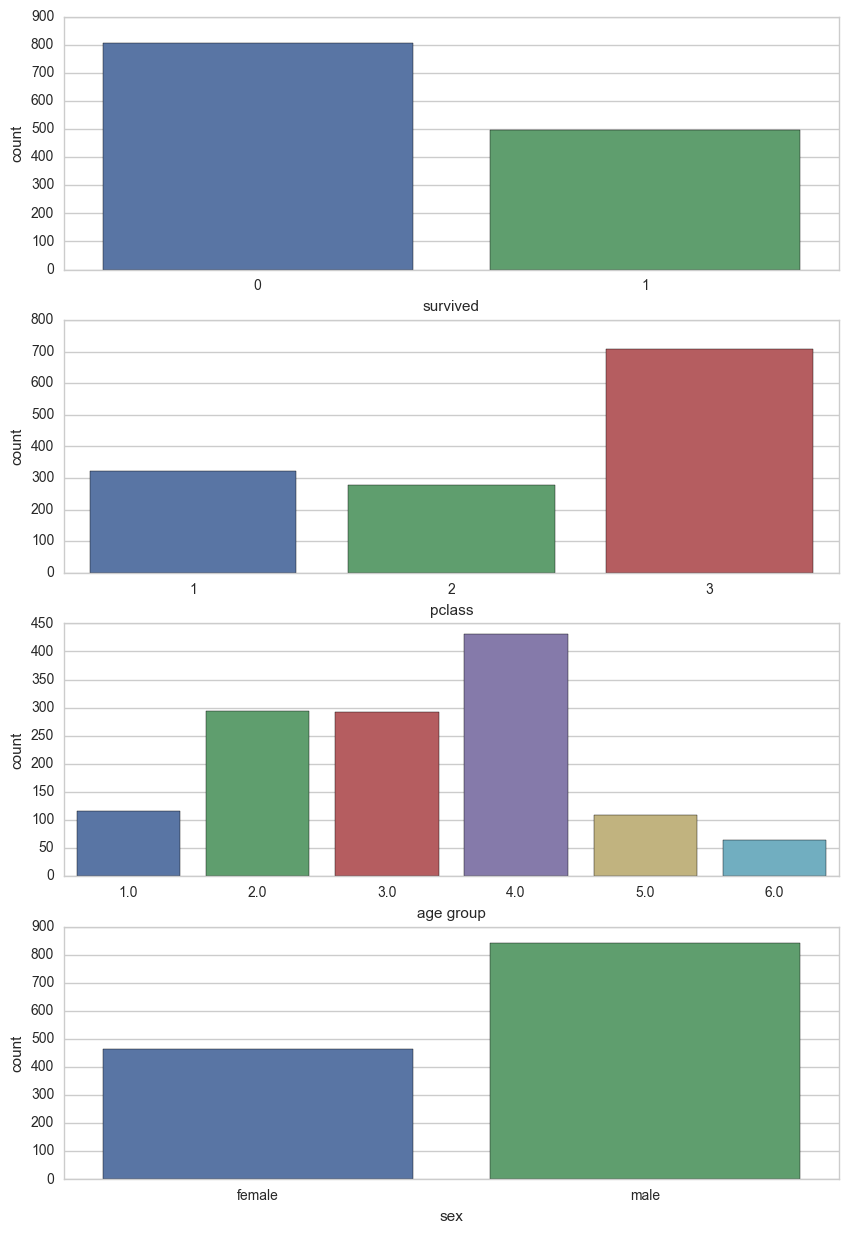

In [168]:
# DATA ANALYSIS
# Firstly we should get to know what is the structure of passengers on Titanic, so we created a few simple plots
# considering the most important variables that we suspect are connected to survival rate: survived, class, age and sex

sns.set_style('whitegrid')
fig, (axis1, axis2, axis3, axis4) = plt.subplots(4, figsize=(10,15))

sns.countplot(x='survived', data=df, ax=axis1)
sns.countplot(x='pclass', data=df, ax=axis2)
sns.countplot(x='age group', data=df, ax=axis3)
sns.countplot(x="sex", data=df, ax=axis4)

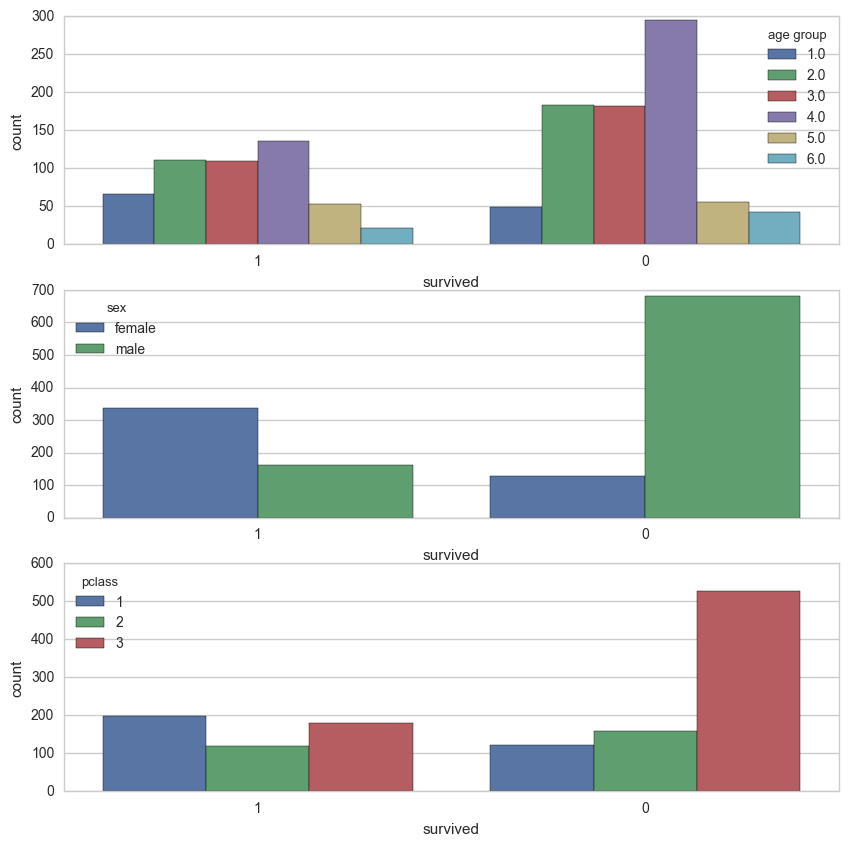

In [169]:
# on the plots above we can see that most of people died during catastrophy. The next two plots give us predictable
# information: Most passengers travelled in third class (about 2,5 times more than in classes 1 or 2) and the largest 
# age group is middle aged one.
# Our next step was to check the same data as before, but divided into survived (1) and not survived (0) categories
sns.set_style('whitegrid')
fig, (axis1, axis2, axis3) = plt.subplots(3, figsize=(10,10))

sns.countplot(x='survived', hue="age group", data=df, order=[1,0], ax= axis1)
sns.countplot(x='survived', hue="sex", data=df, order=[1,0], ax= axis2)
sns.countplot(x='survived', hue="pclass", data=df, order=[1,0], ax=axis3)

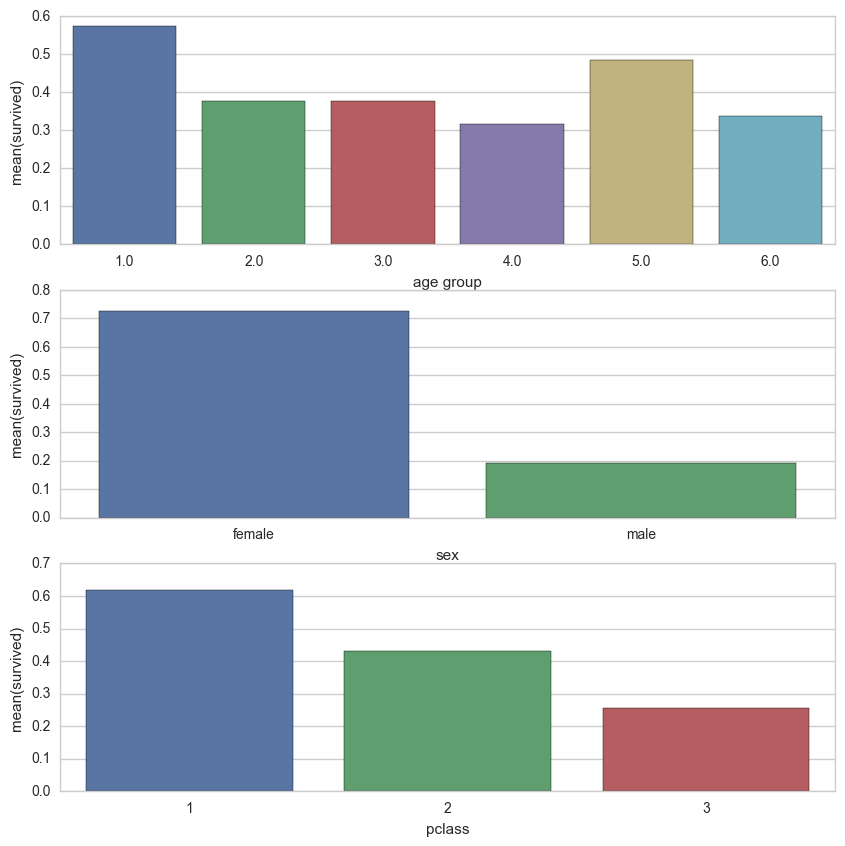

In [170]:
# on the plots above we can see that it appears that age was not related with chance of survival. We can also see that
# women had far greater chance of survival and poeple from the third class had far lower chance of survival. However we
# have to notice that on the Y axis of our plots we have just number of people. To draw any true conclusions we should
# look not at pure numbers, but more at survival ratio, which is
# a mean value of "Survived" in this case. Knowing that, we created plots once again with survival ratio instead of
# division into survived and not survived

sns.set_style('whitegrid')
fig, (axis1, axis2, axis3) = plt.subplots(3, 1 ,figsize=(10,10))

survivalrate_age = df[["age group", "survived"]].groupby(['age group'],as_index=False).mean()
survivalrate_sex = df[["sex", "survived"]].groupby(['sex'],as_index=False).mean()
survivalrate_pclass = df[["pclass", "survived"]].groupby(['pclass'],as_index=False).mean()


sns.barplot(y='survived', x="age group",   data=survivalrate_age, ax= axis1)
sns.barplot(y='survived', x="sex", data=survivalrate_sex,   ax= axis2)
sns.barplot(y='survived', x="pclass", data=survivalrate_pclass,  ax=axis3)

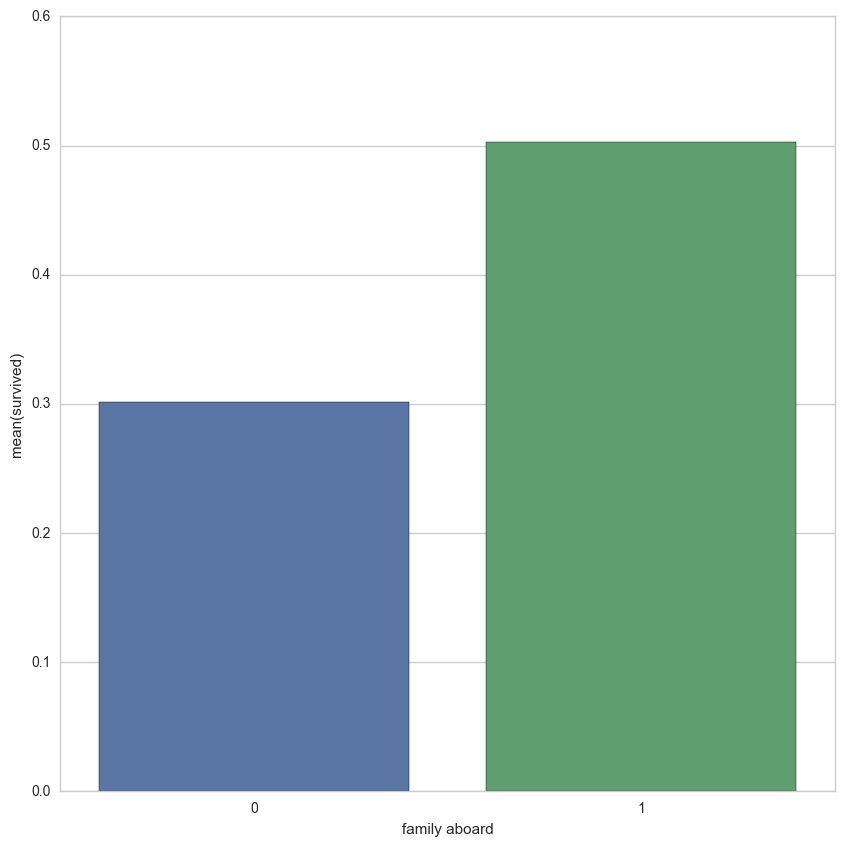

In [223]:
# Now we have far clear view and we should change our drawn conclusions:
# - age group seems to have quite an influence on survival rate. Children (age 0-16) had the best chance of survival,
# they were the only group with chance greater than 50%. The group 5 (age 45-55) is also interesting, as it has
# higher ratio than neighbours. 
# - the difference between survival rate of men and women is drastic: over 70% chance among women, while less than 20% 
# among men.
# This conclusions are probably related to cultural issues, considering "women and children first" european culture
# - We can now see that class of voyage had a great impact on survival chance: Wealthier passengers of first class
#  probably had had better access to rescue boats etc.

# Our next part was to analyse data of lesser(in our opinion)significance to make sure we didn't miss anything important
# We looked at parch and sibsp values, representing numer of parents/children and siblings aboard. 
# We inspired ourselves with this work: https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic/notebook
# and also created a new column "family abroad" with value = 0 if there was no siblings, parents and children in columns
# sibsp and parch or with value = 1 if there were any family members aboard. Then we created a plot considering
# survival rate.


family_aboard = df[["survived", "parch", "sibsp"]]
family_aboard.is_copy = False
family_aboard.loc[:,"family aboard"] = family_aboard["parch"] + family_aboard["sibsp"]
family_aboard.loc[family_aboard["family aboard"] > 0,"family aboard" ] = 1 
family_aboard.loc[family_aboard["family aboard"] == 0, "family aboard"] = 0 

sns.set_style('whitegrid')
fig, axis1 = plt.subplots(1,figsize=(10,10))
survivalrate_family = family_aboard[["family aboard", "survived"]].groupby(['family aboard'],as_index=False).mean()
sns.barplot(y='survived', x="family aboard",   data=survivalrate_family, ax= axis1)

In [172]:
# We can see that having someone close aboard would result in higher sirvival ratio. Probably family members were 
# helping each other, maybe they have higher motivation to survive.

# Lastly we checked fare column. We assumed that people who have paid more are in higher class.
# We calculated mean fare value for every class, as seen below. It seems (as we assumed) that fare 
# and class variables are strongly connected, so no further analysis is needed in our opinion.
print(df.groupby(["pclass"])["fare"].mean())


pclass
1    87.555777
2    21.179196
3    13.302889
Name: fare, dtype: float64


In [173]:
# Lastly we cchange format of data to mumerical for the next exercise 
from sklearn import preprocessing
labelEncoder = preprocessing.LabelEncoder()
df["sex"] = labelEncoder.fit_transform(df["sex"])
df["embarked"] = labelEncoder.fit_transform(df["embarked"])

# Those column was used only for statistical purposes and can worsen machine learning 
# algorithms results, so we drop it
df = df.drop("age group", axis=1)

TASK 2


In [174]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
# We split data to test and train sets, where Y is "Survived" value
dfX = df[df.columns.values[1:]]
dfY = df['survived']
x_train, x_test, y_train, y_test = train_test_split(dfX, dfY, test_size=0.2, random_state=0)

# Let's find default tree classifier
clf = tree.DecisionTreeClassifier()
clf.fit(x_train, y_train)
default_predicted = clf.predict(x_test)

In [175]:
# We will also try finding better classifier using grid search (later we will compare results of default
# tree and the one found with grid search
param_grid = [
    {
        'criterion': ["gini", "entropy"],
        'max_depth': [5, 6, 7, None],
        'min_samples_leaf': [3, 4, 5, 6, 7, 8],
        "min_samples_split": [2, 3, 4, 5, 6]
    }
]

In [176]:
# As our data set is quite well-balanced we want to improve classifier's accuracy,
# therefore we aim at having best accuracy
gridTree = tree.DecisionTreeClassifier()
grid = GridSearchCV(gridTree, param_grid=param_grid, scoring="accuracy")
grid.fit(x_train, y_train)
bestTree = grid.best_estimator_
bestTree.fit(x_train, y_train)
best_predicted = bestTree.predict(x_test)

In [177]:
print("According to best estimator survival rate is:", list(best_predicted).count(1) / len(best_predicted))

According to best estimator survival rate is: 0.2595419847328244


In [178]:
# ----------------------Trees evaluation:--------------------------------------------
print("ESTIMATOR\t cross validation")

print("DEFAULT:\t", accuracy_score(y_test, default_predicted))

print("BEST:\t\t", accuracy_score(y_test, best_predicted))

ESTIMATOR	 cross validation
DEFAULT:	 0.790076335878
BEST:		 0.797709923664


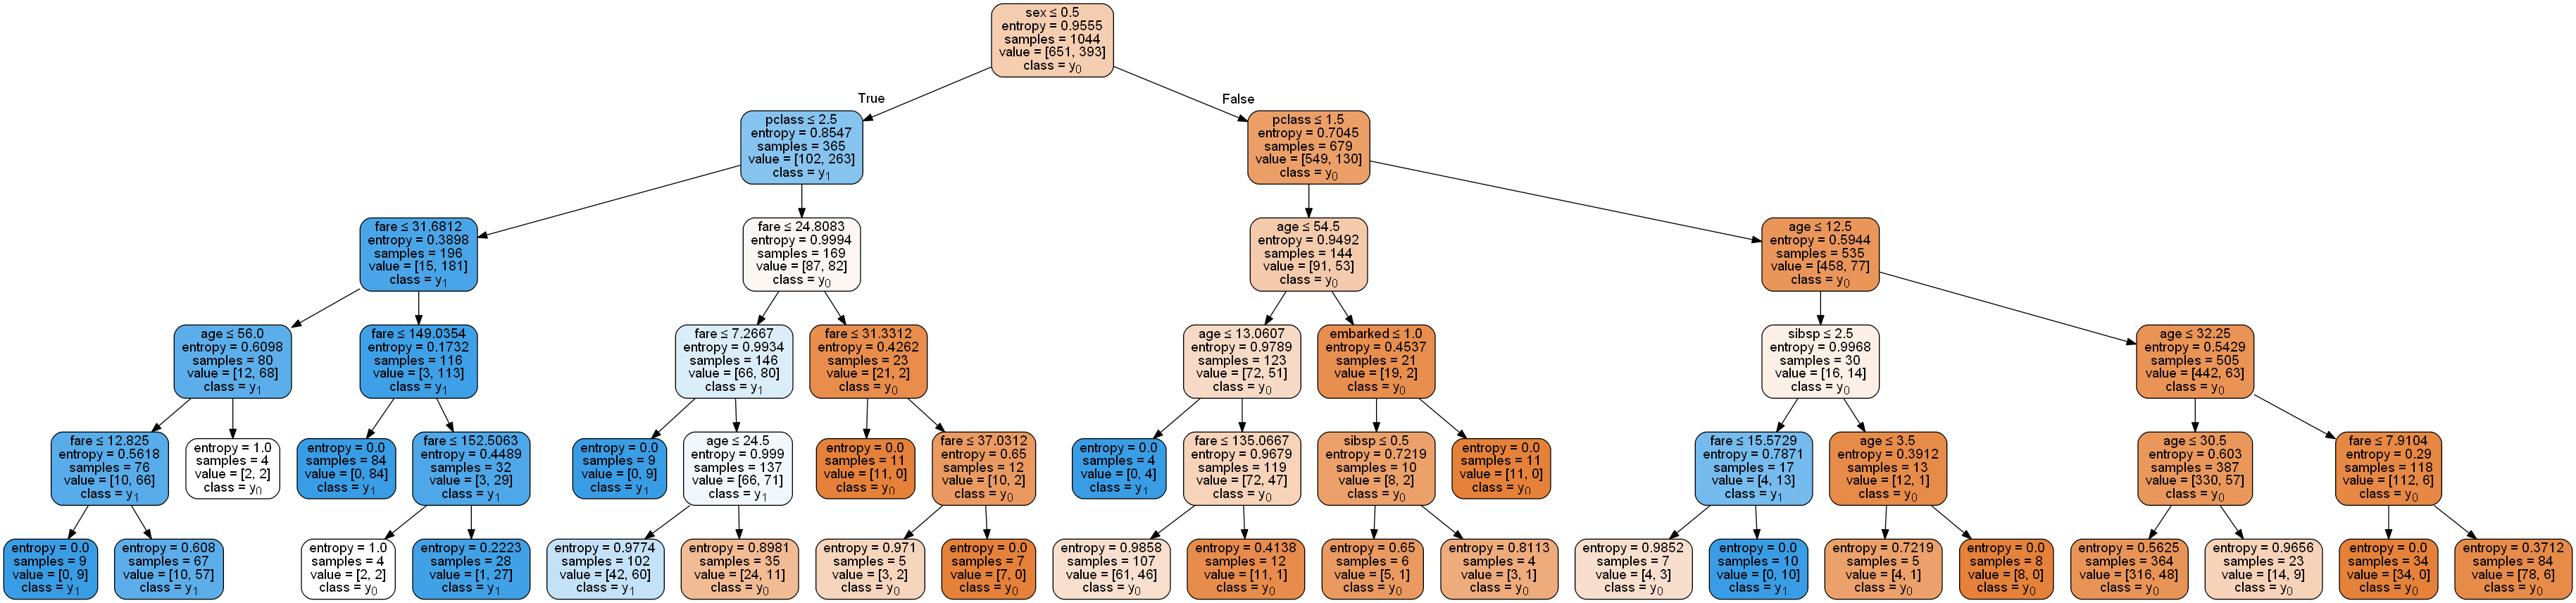

In [87]:
# ------------------Best tree Visualisation----------------------------------------
# We want to see how does our decision tree look like

from IPython.display import Image  
import pydotplus
from sklearn.externals.six import StringIO

dot_data = tree.export_graphviz(bestTree, out_file=None,
                                feature_names=x_test.columns.values[:],
                                class_names=True,
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [228]:
# ----------------------------comparing with baseline-------------------------------
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train, y_train)
knn_predicted = knn.predict(x_test)
print("1NN:\t\t", accuracy_score(y_test, knn_predicted))

x_test_limited = x_test[["pclass"]]
x_train_limited = x_train[["pclass"]]
limited_tree = bestTree
limited_tree.fit(x_train_limited, y_train)
limited_predicted = limited_tree.predict(x_test_limited)
print("features limited:", accuracy_score(y_test, limited_predicted))

1NN:		 0.656488549618
features limited: 0.618320610687


Considering an image of a tree that was created the most important feature is Sex, as we could assume 
by analising data in Task 1. Being a women gave you far greater chance of survival. This can be seen by looking at
nodes' colours: most of nodes where sex is woman are blue, opposite for a man. The next important feature is, as expected, class. Here also analysis in Task 1 showed far greater chances for people from higher class. Next feature commonly used is Age and, suprisingly for us, fare. As for Age feature, we predicted its importance in Task 1, but
we did not thought that fare will be so comonly used (at the same depth as age). This might be due to the similiarity 
of Fare and Class parameters.

TASK 3

In [180]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import euclidean_distances
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

#class of our tree's nodes, store information about split and samples. 
class DecisionNode:
    def __init__(self, result=None):
        self.column = None
        self.value = None
        self.trueChild = None
        self.falseChild = None
        self.result = result
        self.samples = list()
        return

    def isLeaf(self):
        return self.trueChild is None and self.falseChild is None

#divide our set between first, which fulfill condition and second, which do not
def divideSet(X, y, column, value):
    set1X = list()
    set1Y = list()

    set2X = list()
    set2Y = list()
    for rowX, rowY in zip(X, y):
        if rowX[column] <= value:
            set1X.append(rowX)
            set1Y.append(rowY)
        else:
            set2X.append(rowX)
            set2Y.append(rowY)

    set1X = np.asarray(set1X)
    set1Y = np.asarray(set1Y)

    set2X = np.asarray(set2X)
    set2Y = np.asarray(set2Y)
    return set1X, set1Y, set2X, set2Y

#put sample to our tree
def goThrough(curNode, sample):
    while not curNode.isLeaf():
        if sample[curNode.column] <= curNode.value:
            return goThrough(curNode.trueChild, sample)
        else:
            return goThrough(curNode.falseChild, sample)
    return curNode.result


def countEntropy(y):
    import math
    y = list(y)

    if len(y) == 0:
        return 0

    p0 = y.count(0) / len(y)
    p1 = y.count(1) / len(y)
    if p0 == 0 or p1 == 0:
        return 0

    entropy = -((p0 * math.log(p0, 2)) + (p1 * math.log(p1, 2)))

    return entropy


def countGini(y):
    y = list(y)

    if len(y) == 0:
        return 1

    p0 = y.count(0) / len(y)
    p1 = y.count(1) / len(y)
    if p0 == 0 or p1 == 0:
        return 1

    gini = 1 - (pow(p0, 2.00) + pow(p1, 2.00))

    return gini


def countInformationGain(X, y, columnName, value):
    sets = divideSet(X, y, columnName, value)

    samples = len(list(y))
    if samples == 0:
        return 0
    samplesTrue = len(list(sets[1]))
    samplesFalse = len(list(sets[3]))

    trueWeight = samplesTrue / samples
    falseWeight = samplesFalse / samples

    entropyBefore = countEntropy((y))
    entropyTrue = countEntropy(sets[1])
    entropyFalse = countEntropy(sets[3])
    return entropyBefore - (trueWeight * entropyTrue) - (falseWeight * entropyFalse)


def countWholeGini(X, y, columnName, value):
    sets = divideSet(X, y, columnName, value)

    samples = len(list(y))
    if samples == 0:
        return 1
    samplesTrue = len(list(sets[1]))
    samplesFalse = len(list(sets[3]))

    trueWeight = samplesTrue / samples
    falseWeight = samplesFalse / samples

    giniTrue = countGini(sets[1])
    giniFalse = countGini(sets[3])

    return trueWeight * giniTrue + falseWeight * giniFalse


# Find best criterion(column + value) to put in tree node
def findBestSplit(X, y, criterion):
    bestInfGain = 0
    bestInfGini = 1
    bestCol = 0
    bestValue = 0
    for column in range(0, len(X.T)):
        allValues = np.sort(np.unique(X.T[column]))
        if criterion == "entropy":
            for value in allValues:
                curGain = countInformationGain(X, y, column, value)
                if curGain > bestInfGain:
                    bestCol = column
                    bestValue = value
                    bestInfGain = curGain
        elif criterion == "gini":
            for value in allValues:
                curGini = countWholeGini(X, y, column, value)
                if curGini < bestInfGini:
                    bestCol = column
                    bestValue = value
                    bestInfGini = curGini
            bestInfGain = bestInfGini
        else:
            print("Error!")
            return -1

    return bestCol, bestValue, bestInfGain

def buildTree(X, y, minLeafImpurity, curentDepth, criterion, maxDepth):
    if list(y).count(0) >= list(y).count(1) * minLeafImpurity:
        return DecisionNode(result=0)
    if list(y).count(1) >= list(y).count(0) * minLeafImpurity:
        return DecisionNode(result=1)

    node = DecisionNode()
    bestSplitParams = findBestSplit(X, y, criterion)

    if (bestSplitParams[2] == 0 and criterion == "entropy") or \
            (bestSplitParams[2] == 1 and criterion == "gini") \
            or curentDepth > maxDepth:
        if list(y).count(1) > list(y).count(0):
            return DecisionNode(result=1)
        else:
            return DecisionNode(result=0)

    node.samples.append(list(y).count(0))
    node.samples.append(list(y).count(1))

    node.column = bestSplitParams[0]
    node.value = bestSplitParams[1]
    sets = divideSet(X, y, bestSplitParams[0], bestSplitParams[1])
    node.trueChild = buildTree(sets[0], sets[1], minLeafImpurity, curentDepth=curentDepth + 1, criterion=criterion, maxDepth=maxDepth)
    node.falseChild = buildTree(sets[2], sets[3], minLeafImpurity, curentDepth=curentDepth + 1, criterion=criterion, maxDepth=maxDepth)
    return node

In [181]:
class OurTreeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, criterion="entropy", minLeafImpurity=10, maxDepth = 10):
        self.criterion = criterion
        self.minLeafImpurity = minLeafImpurity
        self.maxDepth = maxDepth

    def fit(self, X, y):
        # Check that X and y have correct shape
        self.columnNames = X.columns.values[:]
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        
        self.root = buildTree(X, y, self.minLeafImpurity, 0, self.criterion, self.maxDepth)
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)

        closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        predicted = []
        for sample in X:
            predicted.append(goThrough(self.root, sample))
        return predicted

    
    #Code for printing tree was taken(and then modified for our purposes) from this site:
    #http://www.patricklamle.com/Tutorials/Decision%20tree%20python/tuto_decision%20tree.html
    def printTree(self, tree, indent=''):
        if tree.isLeaf():
            print(str(tree.result))
        else:
            print(str(self.columnNames[tree.column]) + '<=' + str(tree.value) + '? ')
            # Print the branches
            print(indent + 'T->', end=" ")
            self.printTree(tree.trueChild, indent + '  ')
            print(indent + 'F->', end=" ")
            self.printTree(tree.falseChild, indent + '  ')

In [208]:
#use our classifier and count accuracy
clf = OurTreeClassifier(minLeafImpurity=6, criterion="entropy", maxDepth=10)
clf.fit(x_train, y_train)
ourPredicted = clf.predict(x_test)

print("Our survival rate:", list(ourPredicted).count(1) / len(list(ourPredicted)))
print("Accuracy of our tree estimator: ", accuracy_score(y_test, ourPredicted))

param_grid = [
    {
        'criterion': ["entropy", "gini"],
        'maxDepth': [ 4,5,6,7],
        "minLeafImpurity": [7,8,9]
    }
]

gridOurTree = OurTreeClassifier()
gridOur = GridSearchCV(gridOurTree, param_grid=param_grid, scoring="accuracy")
gridOur.fit(x_train, y_train)
bestOurTree = gridOur.best_estimator_
bestOurTree.fit(x_train, y_train)
best_our_predicted = bestOurTree.predict(x_test)

print("Accuracy of our grid tree estimator: ", accuracy_score(y_test, best_our_predicted))

Our survival rate: 0.3893129770992366
Accuracy of our tree estimator:  0.797709923664
Accuracy of our grid tree estimator:  0.824427480916


In [209]:
# - Print the classifiers decision rules (or also visualize them) on the complete data.
clf.printTree(bestOurTree.root)

sex<=0.0? 
T-> pclass<=2.0? 
  T-> 1
  F-> fare<=24.15? 
    T-> fare<=7.25? 
      T-> 1
      F-> age<=16.0? 
        T-> age<=14.5? 
          T-> 1
          F-> 1
        F-> fare<=15.2458? 
          T-> 0
          F-> 1
    F-> 0
F-> pclass<=1.0? 
  T-> age<=54.0? 
    T-> age<=13.0? 
      T-> 1
      F-> fare<=134.5? 
        T-> fare<=110.8833? 
          T-> 0
          F-> 1
        F-> 0
    F-> 0
  F-> age<=12.0? 
    T-> sibsp<=2.0? 
      T-> fare<=15.2458? 
        T-> fare<=12.475? 
          T-> 1
          F-> 0
        F-> 1
      F-> 0
    F-> 0


Our decision tree is quite similar to scikit tree because it uses almost the same features on the same depth of tree. The main difference is that our tree creates leafs faster. 

In [210]:
#compare predictions of our classifier with scikit classifier and print differences 
result = pd.concat([x_test ,y_test],axis=1,join="inner")
result["ourPredicted"] = best_our_predicted
result["bestPredicted"] = best_predicted
result = result.drop(["pclass","sex","age","sibsp","parch","fare","embarked"],axis=1)
result = result[result.ourPredicted != result.bestPredicted]
print(result)

      survived  ourPredicted  bestPredicted
611          1             1              0
1050         1             1              0
1267         0             1              0
1240         1             1              0
759          1             1              0
1082         1             1              0
936          1             1              0
656          1             1              0
1123         1             1              0
1002         1             1              0
684          0             1              0


In [211]:
print("Our estimotor gave other results than scikit Tree in",(len(result["ourPredicted"])/len(y_test))*100,"% " )
print("but int",
      len(result[result["ourPredicted"] == result["survived"]]["survived"])/len(result["ourPredicted"])*100,"% of times that we gave other answer than scikit tree we were right " )

Our estimotor gave other results than scikit Tree in 4.198473282442748 % 
but int 81.81818181818183 % of times that we gave other answer than scikit tree we were right 
